In [34]:
import numpy as np

from matplotlib import pyplot as plt

from snn.graphs import plot_network
from snn.resonator import test_resonator_on_chirp, trained_resonator, delta_resonator, simple_resonator


In [33]:
def resonator_output_spikes_on_chirp(
        my_resonator,
        freq0,
        clk_freq,
        save_figure=False,
        neurons_log_potentials=None,
        neurons_log_spikes=None,
        step=None,
):
    neurons_log_potentials = neurons_log_potentials or []
    for i in neurons_log_potentials:
        my_resonator.log_membrane_potential(i)

    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    start_freq = 0
    spectrum = 4*freq0
    step = step or 1/clk_freq
    test_size = int(spectrum / step)

    print(start_freq, step, test_size, clk_freq)
    test_resonator_on_chirp(
        my_resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
    )

    for i in neurons_log_potentials:
        membrane_neuron = my_resonator.neurons[i]
        y_membrane = membrane_neuron.membrane_potential_graph()
        x = np.linspace(start_freq, start_freq + spectrum, len(y_membrane))
        plt.title(f'membrane potential f={freq0}, neuron={i}')
        plt.plot(x, y_membrane)
        plt.show()

    spikes_window_size = 500
    for i in neurons_log_spikes:
        spikes_neuron = my_resonator.neurons[i]
        y_events = spikes_neuron.out_spikes()
        y_spikes = np.zeros(test_size)
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
        plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
        if save_figure:
            plt.savefig('plot.png', dpi=300, bbox_inches='tight')
            plt.close()
        else:
            plt.plot(x, y_spikes)
            plt.show()

0 6.510416666666667e-05 6389760 1536000


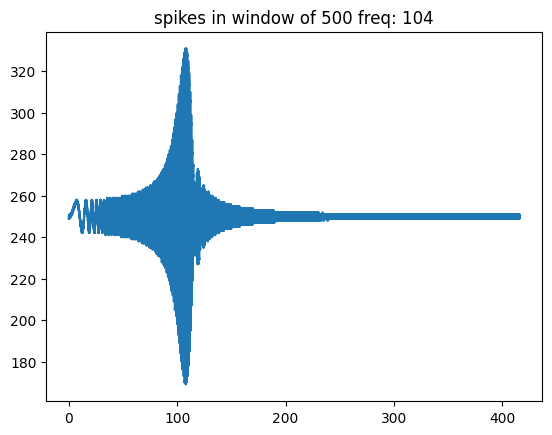

In [36]:
freq0 = 104
my_resonator = simple_resonator(
    freq0, 1536000, 5, [-1, -5, -5 , -5], [11, 9, 10, 10, 10]
)
resonator_output_spikes_on_chirp(my_resonator, freq0=104, clk_freq=1536000, step=100/1536000, neurons_log_spikes=[-1])

0 1.6276041666666666e-05 319488 15360


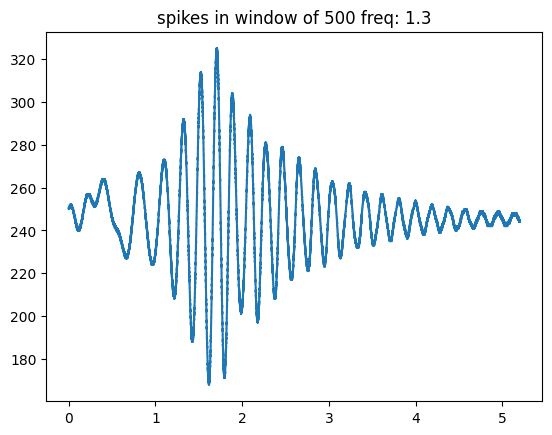

In [9]:
freq0 = 1.3
my_resonator = trained_resonator(
    freq0=freq0,
    filters_folder='filters4_xi0'
)
resonator_output_spikes_on_chirp(my_resonator, freq0=1.3, clk_freq=15360, step=1/15360, neurons_log_spikes=[-1])

In [30]:
from snn.resonator import trained_resonator

def plot_resonator_on_freq(my_resonator, signal_freq, clk_freq, resonator_freq, phases=20, show=True, weights=None, neurons_log_spikes=None, noise_std=0,
                           end_with_n_zeros=0, start_with_n_zeros=0):
    my_resonator.forget_logs()
    neurons_log_spikes = neurons_log_spikes or []
    for i in neurons_log_spikes:
        my_resonator.log_out_spikes(i)

    if type(signal_freq) is not list:
        signal_freq = [signal_freq]

    weights = weights or np.ones(len(signal_freq))

    x = np.linspace(0, phases / resonator_freq, int(phases * clk_freq / resonator_freq))
    t = x * 2 * np.pi * signal_freq[0]
    sine_wave = np.sin(t) * weights[0]
    for w, f in zip(weights[1:], signal_freq[1:]):
        t = x * 2 * np.pi * f
        sine_wave += np.sin(t) * w
    sine_wave += np.random.normal(0, noise_std, len(sine_wave))
    sine_wave /= np.max(sine_wave)

    start_zeros = []
    if start_with_n_zeros > 0:
        start_zeros = np.zeros(int(clk_freq / resonator_freq * start_with_n_zeros))
        my_resonator.input_full_data(start_zeros)
    my_resonator.input_full_data(sine_wave)
    ends_zeros = []
    if end_with_n_zeros > 0:
        ends_zeros = np.zeros(int(clk_freq / resonator_freq *end_with_n_zeros))
        my_resonator.input_full_data(ends_zeros)

    spikes_window_size = 500

    for i in neurons_log_spikes:
        output_neuron = my_resonator.neurons[i]
        y_events = output_neuron.out_spikes()
        y_spikes = np.zeros(len(sine_wave) + len(ends_zeros) + len(start_zeros))
        y_spikes[y_events] = 1
        y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
        plt.title(f'signal freq {signal_freq}')
        plt.plot(np.linspace(0, phases + end_with_n_zeros + start_with_n_zeros, len(y_spikes)), y_spikes, label=f'SN {i}')

    if show:
        plt.show()

    return my_resonator

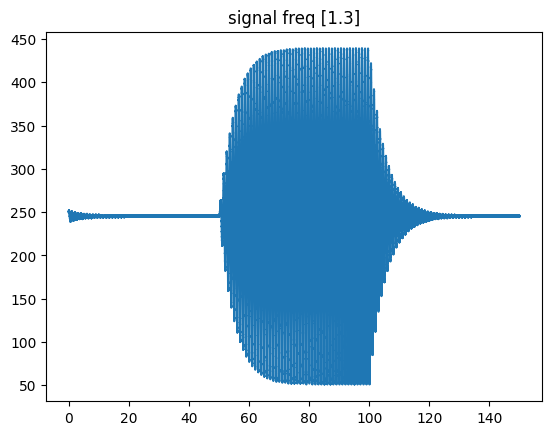

In [31]:
freq0 = 1.3
resonator221 = trained_resonator(
        freq0=float(freq0),
        filters_folder='filters4_xi0'
    )
plot_resonator_on_freq(resonator221, freq0, clk_freq=15360, resonator_freq=freq0,
                       show=True, neurons_log_spikes=[-1], phases=50, end_with_n_zeros=50, start_with_n_zeros=50)


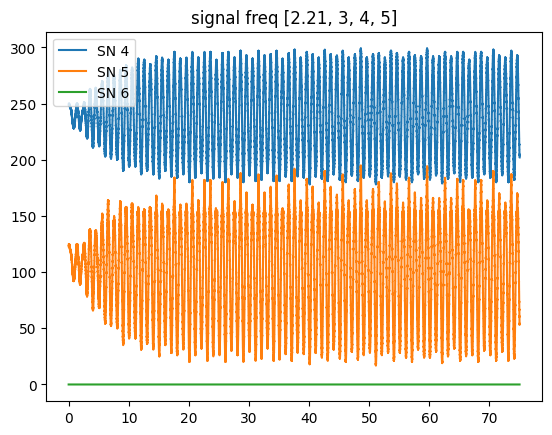

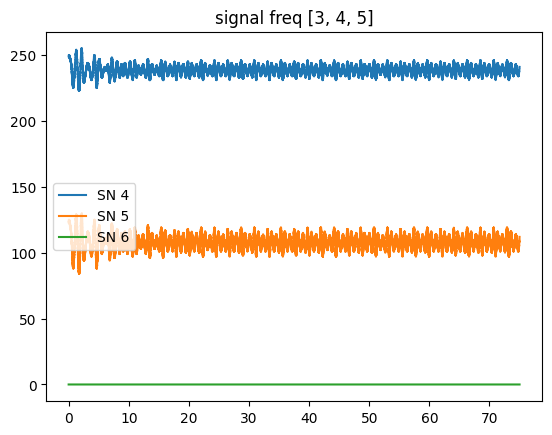

In [34]:
f_resonator = 2.21

resonator221 = delta_resonator(
        freq0=float(f_resonator),
        filters_folder='filters4_xi0'
    )
noise_freqs = [2.21] + [3, 4, 5]
plot_resonator_on_freq(resonator221, noise_freqs,# weights=[.5] + [.5]*(len(noise_freqs) - 1 ),
                       clk_freq=15360, resonator_freq=f_resonator, show=False, neurons_log_spikes=[4, 5, 6],
                       phases=75, noise_std=0)
plt.legend()
plt.show()


resonator221 = delta_resonator(
        freq0=float(f_resonator),
        filters_folder='filters4_xi0'
    )
noise_freqs = [3, 4, 5]
plot_resonator_on_freq(resonator221, noise_freqs,# weights=[.5] + [.5]*(len(noise_freqs) - 1 ),
                       clk_freq=15360, resonator_freq=f_resonator, show=False, neurons_log_spikes=[4, 5, 6],
                       phases=75, noise_std=0)
plt.legend()
plt.show()

## Depict Phase Shifting

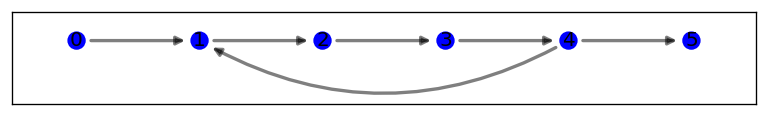

In [5]:
from snn.graphs import plot_network
from snn.resonator import create_excitatory_inhibitory_resonator, create_excitatory_resonator

my_resonator = create_excitatory_resonator(freq0=104, clk_freq=1536000)
# my_resonator = create_excitatory_resonator(freq0='5.900', clk_freq=76800)
plot_network(my_resonator)

In [6]:
from snn.resonator import create_base_resonator, simple_resonator

clk_freq = 1536000
resonator_freq = 104
# clk_freq = 76800
duration = 1.5
# resonator_freq = '5.900'
# my_resonator = create_excitatory_resonator(freq0=resonator_freq, clk_freq=clk_freq)

# resonator0 = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)
resonator0 = simple_resonator(freq0=resonator_freq, clk_freq=clk_freq, lf=5, thetas=[-1, -5, -5, -5], weights=[11, 9, 10, 10, 10])
resonator0.amplitude[0] = 10_000.0
resonator0.log_out_spikes(0)

# my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)
my_resonator = simple_resonator(freq0=resonator_freq, clk_freq=clk_freq, lf=5, thetas=[-1, -5, -5, -5], weights=[11, 9, 10, 10, 10])

signal_freq = 104

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

# my_resonator.input_full_data(np.zeros(clk_freq * 5))
# for i in neurons_log_spikes:
#     output_neuron = my_resonator.neurons[i]
#     output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)
resonator0.input_full_data(sine_wave)
None

<string>:3: NumbaTypeSafetyWarning: unsafe cast from int64 to int32. Precision may be lost.


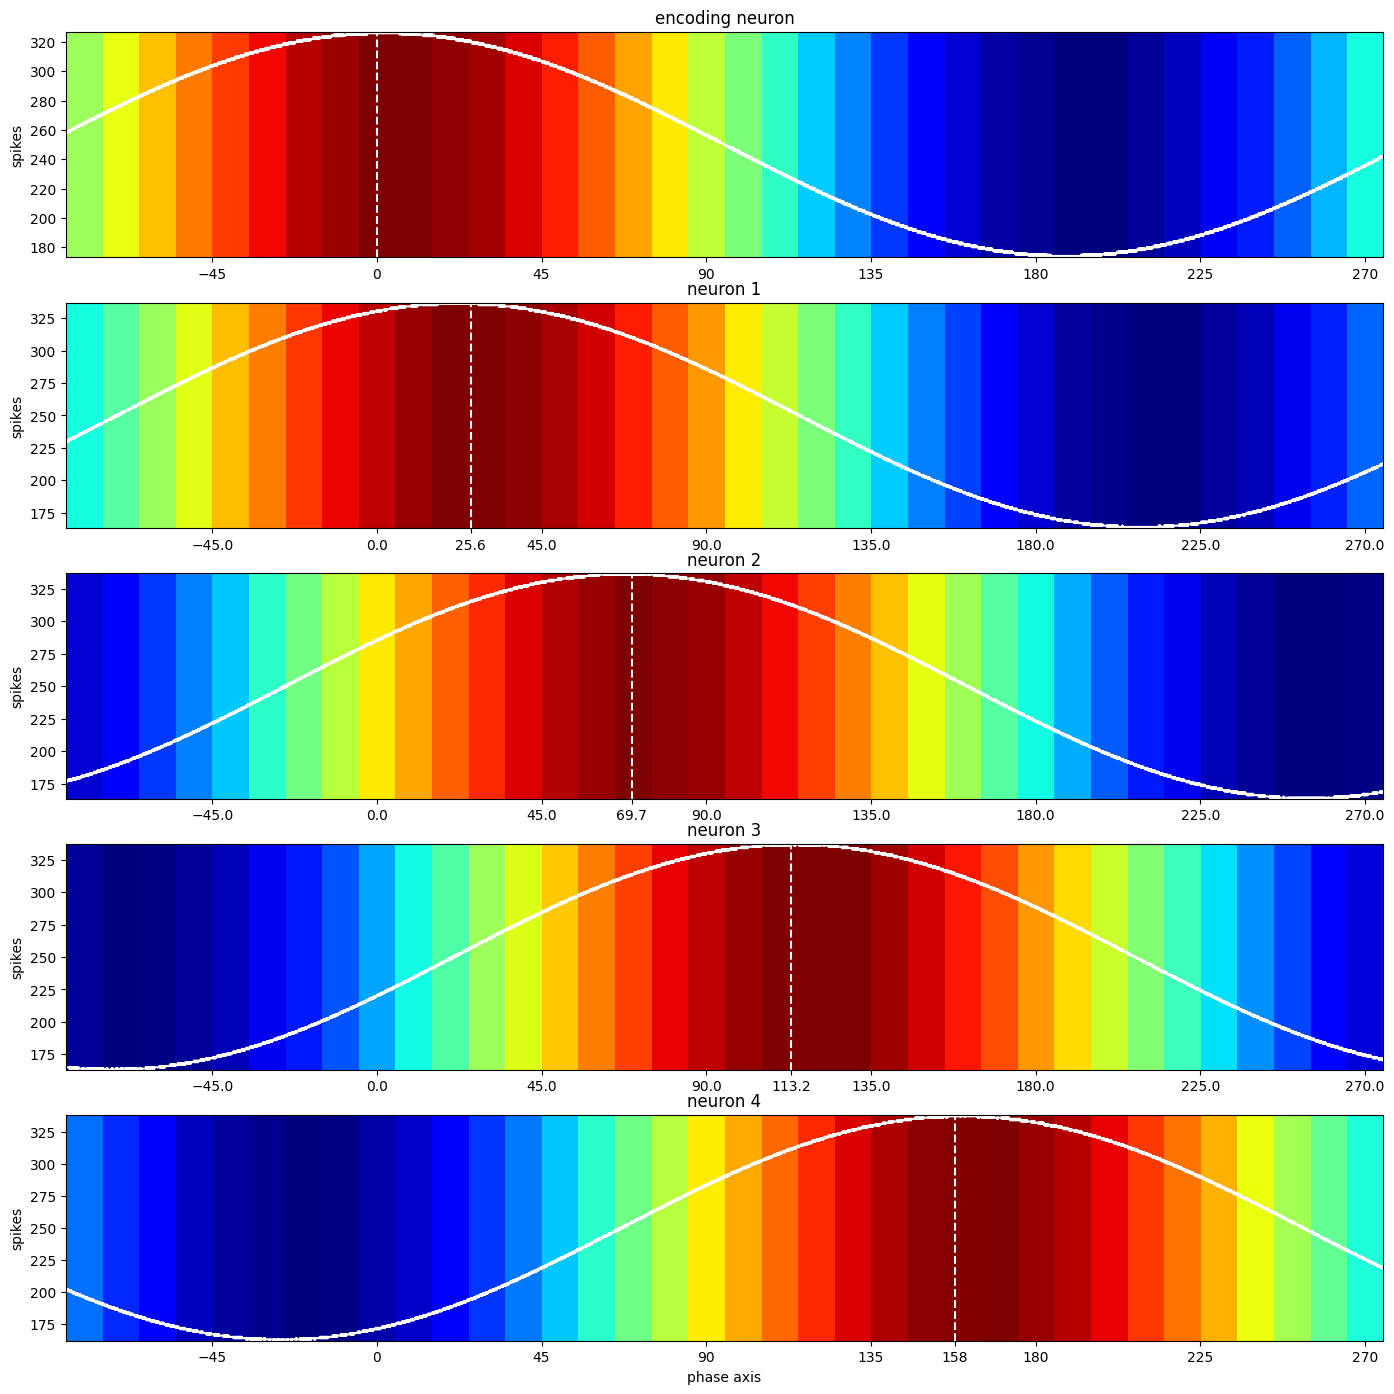

In [8]:
fig, axs = plt.subplots(5, 1, figsize=(17, 17))
phase_shift = [25.6, 44.1, 43.5, 44.7]
labels = ['input'] + [f'shift by {i}' for i in phase_shift]
for i in neurons_log_spikes:
    spikes_window_size = 500
    if i == 0:
        output_neuron = resonator0.neurons[i]
    else:
        output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (3/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(int(clk_freq / signal_freq))
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')

    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)

    bin_window = 400
    pdm = y_spikes[:-(len(y_spikes)%bin_window)]
    pdm = pdm.reshape(-1, bin_window).sum(axis=1)
    pdm = np.array([pdm])
    ax = axs[i]
    if i == 0:
        ax.set_title(f'encoding neuron')
    else:
        ax.set_title(f'neuron {i}')
    pivot = 85
    im = ax.imshow(pdm, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0-pivot, 360-pivot, min_spikes, max_spikes],
               )
    if i == 0:
        ax.vlines(0, min_spikes, max_spikes, color='w', linestyle='--')
        ax.set_xticks([-45, 0, 45, 90, 135, 180, 225, 270])
    else:
        peak = sum(phase_shift[:i])
        ax.vlines(peak, min_spikes, max_spikes, color='w', linestyle='--')
        ax.set_xticks(sorted([-45, 0, 45, 90, 135, 180, 225, 270] + [peak]))
    # fig.colorbar(im, ax=ax)
    ax.plot(np.linspace(0-pivot, 360-pivot, len(y_spikes_rollsum)), y_spikes_rollsum, color='w')
    ax.set_ylabel('spikes')


    if i == 4:
        ax.set_xlabel('phase axis')

plt.show()

## Depict Resonator

In [6]:
from snn.resonator import create_chirp_signal, create_base_resonator
from numba import njit


@njit
def test_frequency(network, test_size=10_000_000, start_freq=0, step=1 / 200000, clk_freq=1536000):
    batch_size = 50_000
    shift = 0
    while test_size > 0:
        sine_size = min(batch_size, test_size)
        sine_wave, freqs = create_chirp_signal(sine_size, clk_freq, start_freq, step, shift)

        network.input_full_data(sine_wave)

        shift = freqs[-1]
        start_freq += sine_size * step
        test_size -= sine_size

def custom_resonator_output_spikes(
        resonator,
        freq0,
        clk_freq,
        sample_rate=1,
        step = None,
        save_figure=False,
        path=None,
        plot=True
):
    resonator.log_out_spikes(-1)
    start_freq = 0
    spectrum = 2 * freq0
    step = step or 1 / clk_freq / sample_rate
    test_size = int(spectrum / step)
    spikes_neuron = resonator.neurons[-1]

    spikes_neuron.membrane_sample_max_window = np.zeros(1).astype('float32')
    test_frequency(
        resonator,
        start_freq=start_freq,
        step=step,
        test_size=test_size,
        clk_freq=clk_freq
   )

    events = spikes_neuron.out_spikes()
    y_spikes = np.zeros(events[-1] + 1)
    y_spikes[events] = 1

    if path is not None:
        np.savez_compressed(path, spikes=y_spikes)

    spikes_window_size = 1000
    y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    x = np.linspace(start_freq, start_freq + spectrum, len(y_spikes))
    plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
    plt.plot(x, y_spikes)
    if save_figure:
        plt.savefig(f'../filters/clk_{clk_freq}/figures/f_{freq0:.3f}.PNG', bbox_inches='tight')
        plt.close()
    elif plot:
        plt.show()


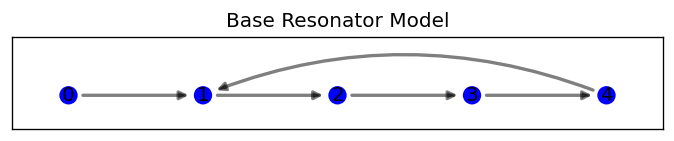

In [5]:

freq0 = 5.9
clk_freq = 76800
resonator = create_base_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')
None

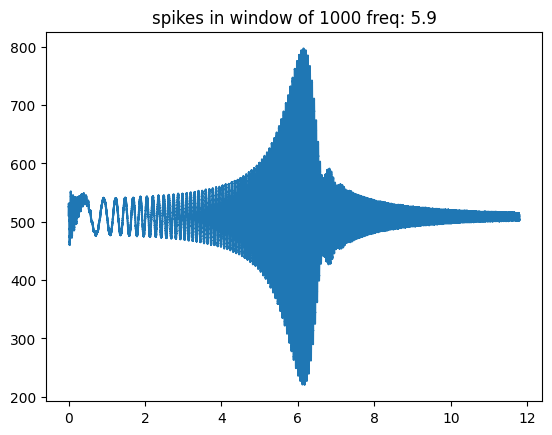

In [586]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

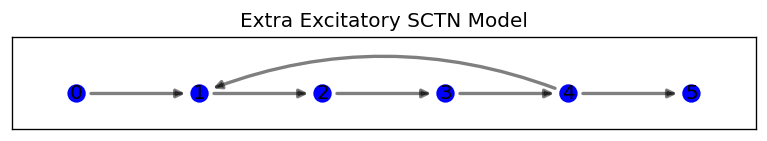

In [9]:
resonator = create_excitatory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Extra Excitatory SCTN Model')
None

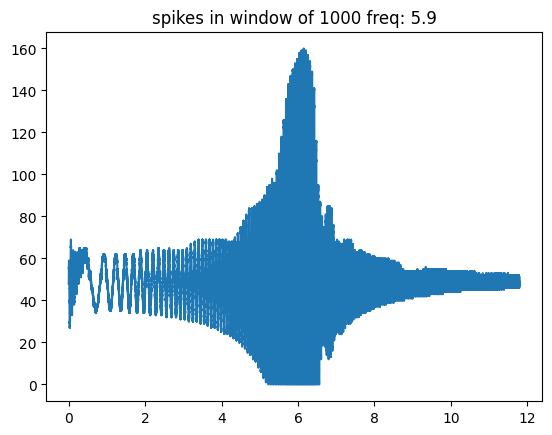

In [585]:
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=3)

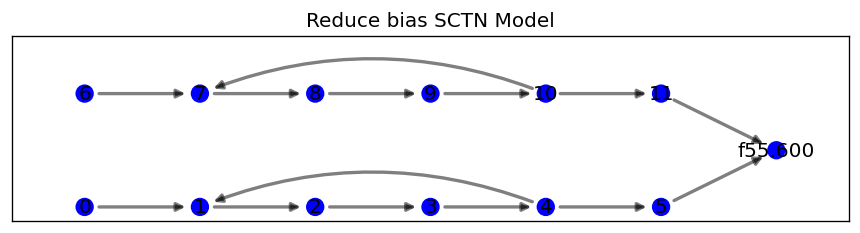

In [15]:
clk_freq = 614400
freq0 = 55.600
resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Reduce bias SCTN Model')
None

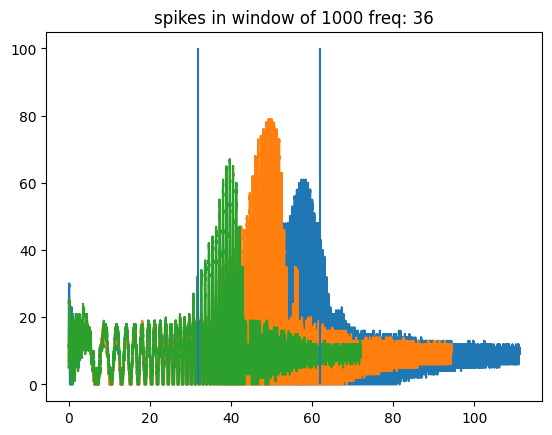

In [23]:
freqs = [36, 47.2, 55.6]
freqs.reverse()
for freq0 in freqs:
    resonator = create_excitatory_inhibitory_resonator(freq0=f'{freq0:.3f}', clk_freq=clk_freq)
    custom_resonator_output_spikes(resonator, freq0, clk_freq, step=1/20000, plot=False)

plt.vlines(32, 0, 100)
plt.vlines(62, 0, 100)
plt.show()

### Check Resonator 104 Amplitudes!

Text(0.5, 1.0, 'Base Resonator Model')

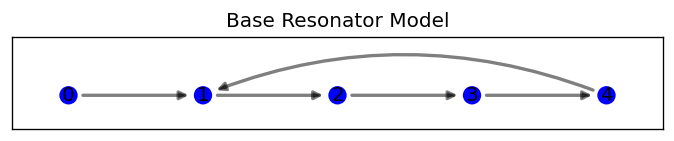

In [14]:
freq0 = 104
clk_freq = 1536000
resonator = create_base_resonator(freq0=f'{freq0}', clk_freq=clk_freq)
plot_network(resonator)
plt.title('Base Resonator Model')

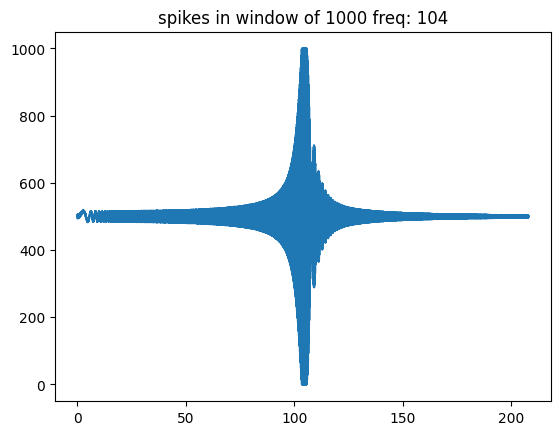

In [19]:
resonator.neurons[-1].forget_logs()
custom_resonator_output_spikes(resonator, freq0, clk_freq, sample_rate=1, step=1/100000)

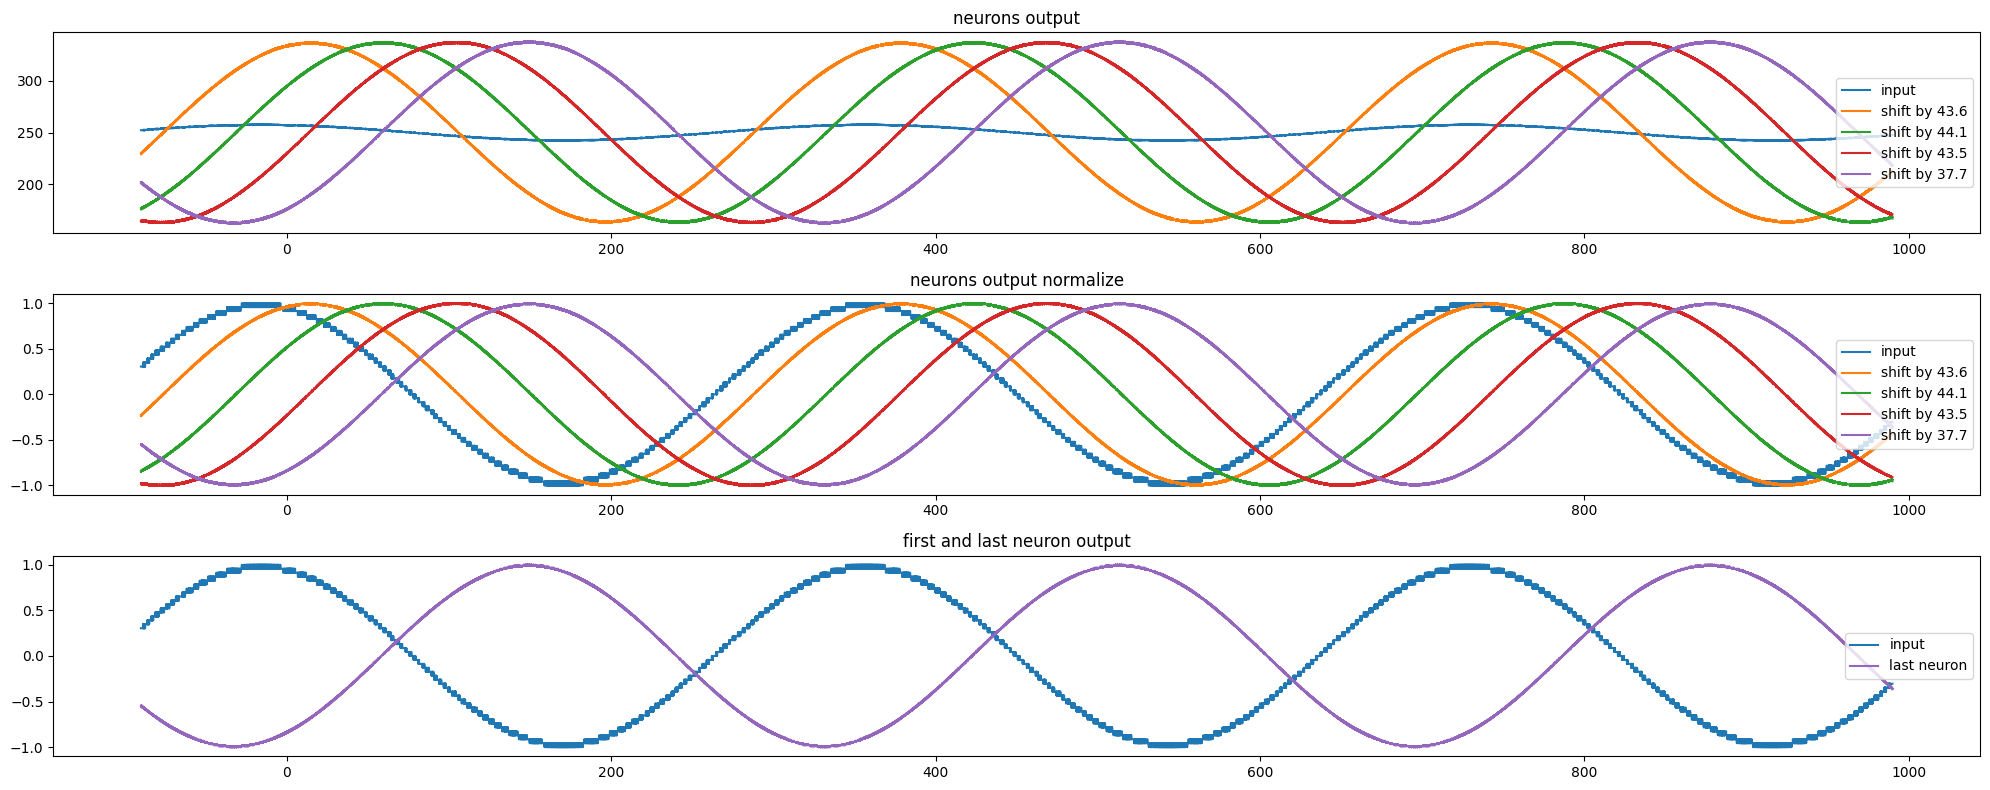

In [37]:
duration = 3

# resonator_freq = '104'
resonator_freq = 104
clk_freq = 1536000
my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)

signal_freq = 104
cycles = 3

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

my_resonator.input_full_data(sine_wave)

spikes_window_size = 500
fig, axs = plt.subplots(3, 1, figsize=(20, 8))
labels0 = [
    'input',
    'shift by 43.6',
    'shift by 44.1',
    'shift by 43.5',
    'shift by 37.7',
]
for i in neurons_log_spikes:
    if i == 0:
        spikes_window_size = 1500
    else:
        spikes_window_size = 500
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - ((6+cycles)/signal_freq)) * clk_freq) & (y_events < (duration - (6/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(int(cycles * clk_freq / signal_freq + 1))
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1
    pivot = 90

    if i == 0:
        axs[2].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=labels0[i])
        y_spikes_rollsum /= 3
    axs[0].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(y_spikes_rollsum)), y_spikes_rollsum, label=labels0[i])
    axs[1].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=labels0[i])
    if i == 4:
        axs[2].plot(np.linspace(0 - pivot, cycles * 360 - pivot, len(normalize_roll)), normalize_roll, label=f'last neuron', color='tab:purple')

axs[0].set_title('neurons output')
axs[1].set_title('neurons output normalize')
axs[2].set_title('first and last neuron output')
axs[0].legend(loc='right')
axs[1].legend(loc='right')
axs[2].legend(loc='right')
plt.tight_layout()
plt.show()

In [116]:
output_neuron = my_resonator.neurons[0]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll0 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll0 = normalize_roll0*2-1

output_neuron = my_resonator.neurons[-1]
y_events = output_neuron.out_spikes()
y_events = y_events[(y_events > (duration - (10/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
y_events -= y_events[0]
y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
# y_spikes = np.zeros(y_events[-1] + 1)
y_spikes[y_events] = 1
y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
max_spikes = np.max(y_spikes_rollsum)
min_spikes = np.min(y_spikes_rollsum)
normalize_roll1 = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
normalize_roll1 = normalize_roll1*2-1
signal_length = min(len(normalize_roll1), len(normalize_roll0))
print(f'mse {np.sum((normalize_roll1[:signal_length] + normalize_roll0[:signal_length]) ** 2)/signal_length}')

mse 0.0001319395965263285


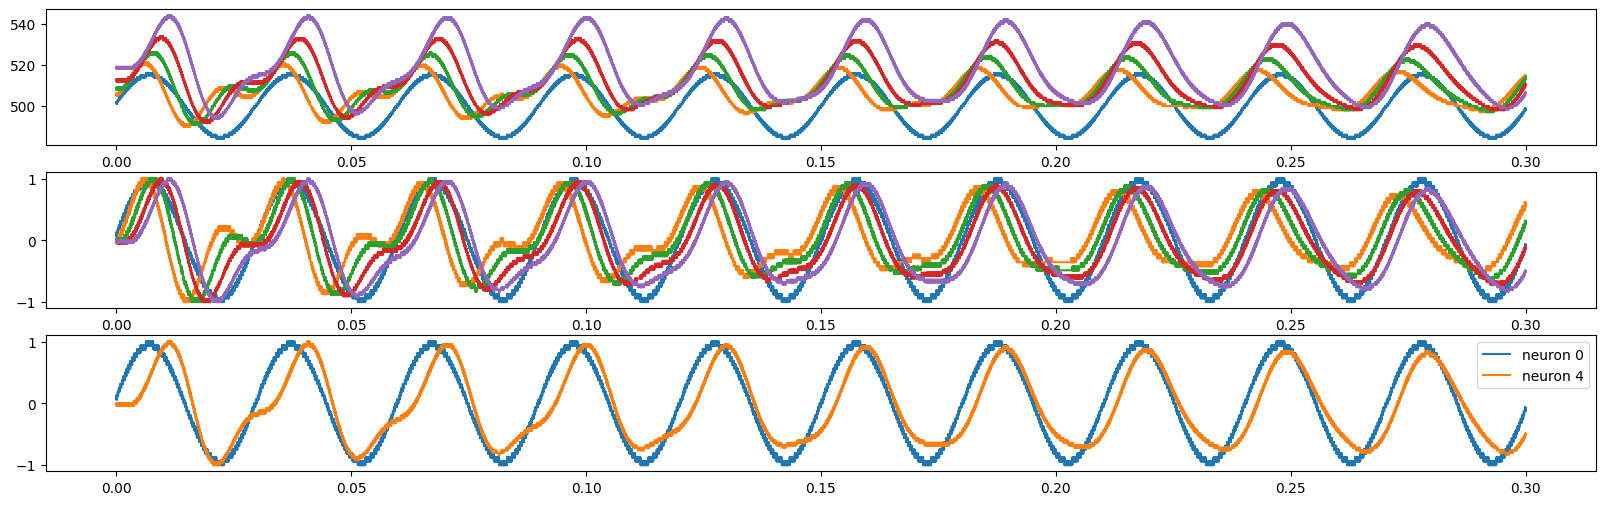

In [59]:
duration = .3

resonator_freq = '104'
clk_freq = 1536000
my_resonator = create_base_resonator(freq0=resonator_freq, clk_freq=clk_freq)

signal_freq = 50

neurons_log_spikes = range(5)
for i in neurons_log_spikes:
    my_resonator.log_out_spikes(i)

spectrum = duration

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * signal_freq
sine_wave = np.sin(t)

my_resonator.input_full_data(np.zeros(clk_freq * 1))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    output_neuron.forget_logs()
my_resonator.input_full_data(sine_wave)

spikes_window_size = 1000

fig, axs = plt.subplots(3, 1, figsize=(20, 6))
for i in neurons_log_spikes:
    output_neuron = my_resonator.neurons[i]
    y_events = output_neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (15/signal_freq)) * clk_freq) & (y_events < (duration - (5/signal_freq)) * clk_freq)]
    y_events -= y_events[0]
    y_spikes = np.zeros(y_events[-1] + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    normalize_roll = normalize_roll*2-1

    axs[0].plot(np.linspace(0, duration, len(y_spikes_rollsum)), y_spikes_rollsum, label=f'neuron {i}')
    axs[1].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')
    if i == 0 or i == 4:
        axs[2].plot(np.linspace(0, duration, len(normalize_roll)), normalize_roll, label=f'neuron {i}')

plt.legend()
plt.show()